In [32]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import contextily as cx
import warnings
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from patsy import dmatrices
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

data_dir = "C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/9.Data/"
map_dir = "C:/Users/mmh/OneDrive - Oak Ridge National Laboratory/Melrose/8.Maps/"

# read zip code -> tract

dictionary: https://www.census.gov/programs-surveys/geography/technical-documentation/records-layout/2010-zcta-record-layout.html

In [36]:
z_tract = pd.read_csv(data_dir + 'NYS open portal/zcta_tract_rel_10.txt', sep=",")
z_tract = z_tract[z_tract.STATE==36]
z_tract['ZCTA5'] = z_tract['ZCTA5'].astype(str).str.zfill(5)
z_tract['ZCTA5'] = pd.to_numeric(z_tract['ZCTA5'])

z_tract = z_tract[z_tract.ZPOPPCT>25]
# match zcta with the census with the largest proportion of population 
z_tract = z_tract.sort_values('ZPOPPCT', ascending=False).groupby(['ZCTA5']).first().reset_index()
print(len(z_tract))
%store z_tract
z_tract.head()

1473
Stored 'z_tract' (DataFrame)


,ZCTA5,STATE,COUNTY,TRACT,GEOID,POPPT,HUPT,AREAPT,AREALANDPT,ZPOP,ZHU,ZAREA,ZAREALAND,TRPOP,TRHU,TRAREA,TRAREALAND,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT,TRPOPPCT,TRHUPCT,TRAREAPCT,TRAREALANDPCT
0,6390,36,103,170202,36103170202,236,660,10936841,10555961,236,660,10936841,10555961,4029,4036,141980107,41415321,100.00,100.00,100.00,100.00,5.86,16.35,7.70,25.49
1,10004,36,61,1300,36061001300,1456,1071,46093,46093,3089,2197,1449744,1449744,4479,3068,311985,311985,47.13,48.75,3.18,3.18,32.51,34.91,14.77,14.77
2,10005,36,61,700,36061000700,6839,4619,174566,174566,7135,5317,190416,190416,8109,5447,449278,253931,95.85,86.87,91.68,91.68,84.34,84.80,38.85,68.75
3,10006,36,61,1300,36061001300,3011,1991,237784,237784,3011,1991,237784,237784,4479,3068,311985,311985,100.00,100.00,100.00,100.00,67.22,64.90,76.22,76.22
4,10007,36,61,2100,36061002100,5284,2609,211690,211690,6988,3143,423358,423358,6040,3020,242766,242766,75.62,83.01,50.00,50.00,87.48,86.39,87.20,87.20


<AxesSubplot: xlabel='Overlap percentage', ylabel='Number of qualified ZCTA5'>

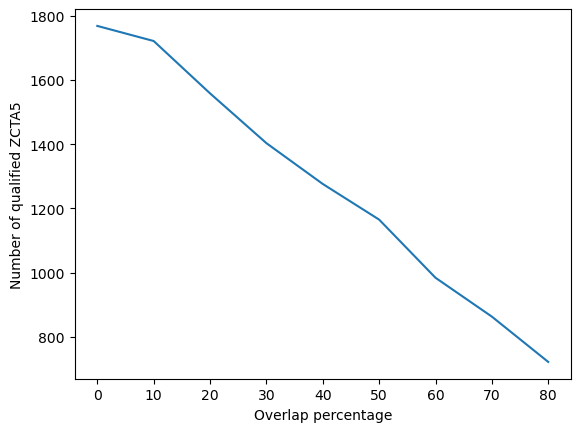

In [41]:
res = []
for j in range(9):
    z_tract = pd.read_csv(data_dir + 'NYS open portal/zcta_tract_rel_10.txt', sep=",")
    z_tract = z_tract[z_tract.STATE==36]
    z_tract['ZCTA5'] = z_tract['ZCTA5'].astype(str).str.zfill(5)
    z_tract['ZCTA5'] = pd.to_numeric(z_tract['ZCTA5'])

    z_tract = z_tract[z_tract.ZPOPPCT>j*10]
    # match zcta with the census with the largest proportion of population 
    z_tract = z_tract.sort_values('ZPOPPCT', ascending=False).groupby(['ZCTA5']).first().reset_index()
    res.append([j,len(z_tract)])
res = pd.DataFrame(res,columns=['Overlap percentage','Number of qualified ZCTA5'])
res['Overlap percentage'] = res['Overlap percentage']*10


(0.0, 2000.0)

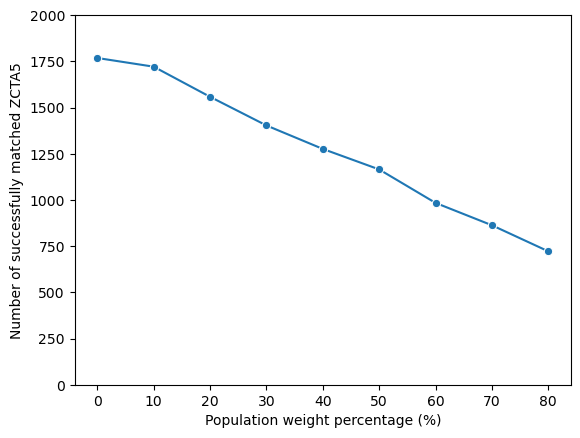

In [46]:
sns.lineplot(data=res,x='Overlap percentage',y='Number of qualified ZCTA5', marker='o')
plt.xlabel('Population weight percentage (%)')
plt.ylabel('Number of successfully matched ZCTA5')
plt.ylim(0,2000)

<AxesSubplot: xlabel='ZAREA', ylabel='Count'>

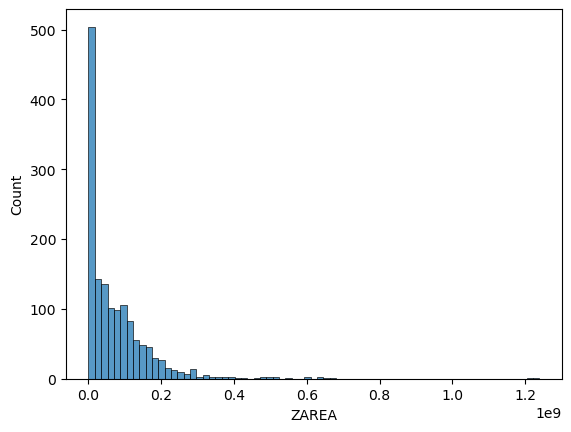

In [3]:
sns.histplot(data = z_tract, x= "ZAREA")

<AxesSubplot: xlabel='ZPOPPCT', ylabel='Count'>

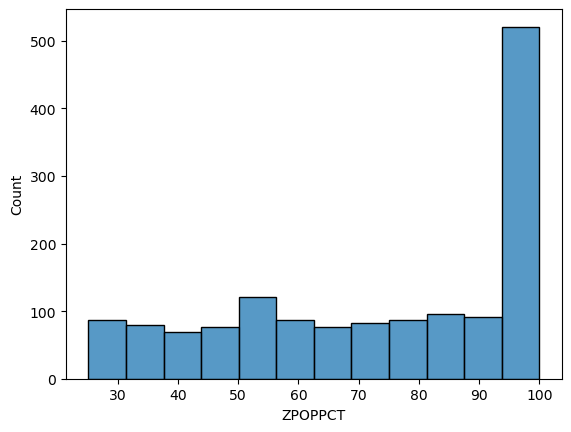

In [4]:
sns.histplot(data = z_tract, x= "ZPOPPCT")

In [5]:
np.mean(z_tract.ZPOPPCT)

73.99515953835709

In [6]:
z_tract = z_tract[z_tract.ZPOPPCT>20]
len(z_tract[z_tract.ZPOPPCT>=60])/len(z_tract)*100

66.80244399185335

# read zip codes US

In [7]:
zips = gpd.read_file(map_dir + 'geo/tl_2019/tl_2019_us_zcta510.zip')
zips = zips.rename(columns={'ZCTA5CE10':'ZCTA5'})
zips['ZCTA5'] = pd.to_numeric(zips['ZCTA5'])
zips.head()

,ZCTA5,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,43451,43451,B5,G6350,S,63484186,157689,+41.3183010,-083.6174935,"POLYGON ((-83.70873 41.32733, -83.70815 41.327..."
1,43452,43452,B5,G6350,S,121522304,13721730,+41.5157923,-082.9809454,"POLYGON ((-83.08698 41.53780, -83.08256 41.537..."
2,43456,43456,B5,G6350,S,9320975,1003775,+41.6318300,-082.8393923,"MULTIPOLYGON (((-82.83558 41.71082, -82.83515 ..."
3,43457,43457,B5,G6350,S,48004681,0,+41.2673301,-083.4274872,"POLYGON ((-83.49650 41.25371, -83.48382 41.253..."
4,43458,43458,B5,G6350,S,2573816,39915,+41.5304461,-083.2133648,"POLYGON ((-83.22229 41.53102, -83.22228 41.532..."


In [8]:
print(len(zips))

33144


In [9]:
# zips = zips[zips.ZCTA5.isin(ev.ZCTA5)]
# zips.to_file('tl_2019_us_zcta510_NYS.shp')  

# CNT

In [10]:
cnt = pd.read_csv(data_dir + 'CNT/htaindex2019_data_tracts_36.csv')
cnt['tract'] = cnt['tract'].apply(lambda s:s.replace('"', ""))
cnt['TRACT'] = cnt['tract'].str.strip().str[-6:]
cnt['TRACT'] = pd.to_numeric(cnt['TRACT'])

# group to tract level (rather than block group)
cnt = cnt.groupby('TRACT').mean().reset_index()
print(len(cnt))
# remove census tracts
cnt = pd.merge(z_tract[['ZCTA5','TRACT']],cnt,how='left',on='TRACT')
cnt_var = ['h_ami','t_ami']
print(len(cnt))
cnt.head()

2694
1473


,ZCTA5,TRACT,blkgrps,population,households,land_acres,ht_ami,ht_80ami,ht_nmi,h_ami,h_80ami,h_nmi,t_ami,t_80ami,t_nmi,co2_per_hh_local,co2_per_acre_local,autos_per_hh_ami,autos_per_hh_80ami,autos_per_hh_nmi,vmt_per_hh_ami,vmt_per_hh_80ami,vmt_per_hh_nmi,pct_transit_commuters_ami,pct_transit_commuters_80ami,pct_transit_commuters_nmi,t_cost_ami,t_cost_80ami,t_cost_nmi,auto_ownership_cost_ami,auto_ownership_cost_80ami,auto_ownership_cost_nmi,vmt_cost_ami,vmt_cost_80ami,vmt_cost_nmi,transit_cost_ami,transit_cost_80ami,transit_cost_nmi,transit_trips_ami,transit_trips_80ami,transit_trips_nmi,compact_ndx,emp_ovrll_ndx,res_density,gross_hh_density,hh_gravity,frac_sfd,emp_gravity,emp_ndx,block_size,intersection_density,avg_block_perimeter_meters,h_cost,median_smoc,median_gross_rent,pct_owner_occupied_hu,pct_renter_occupied_hu
0,6390,170202,5.000000,4242.000000,1983.000000,10220.990000,55.000000,67.000000,67.000000,35.000000,43.000000,43.000000,20.000000,23.000000,23.000000,7.340000,2.730000,1.990000,2.000000,2.000000,19550.000000,19369.000000,19158.000000,1.000000,1.000000,1.000000,15731.000000,14701.000000,14587.000000,12519.000000,11519.000000,11441.000000,3147.000000,3117.000000,3083.000000,65.000000,65.000000,64.000000,10.000000,10.000000,10.000000,2.300000,3.800000,0.610000,0.190000,4444.000000,81.000000,5108.000000,82.000000,29.000000,49.000000,3176.000000,2274.000000,2473.000000,1410.000000,90.000000,10.000000
1,10004,1300,3.000000,3452.714286,1525.571429,929.884286,40.000000,49.000000,44.571429,25.571429,32.000000,29.428571,14.142857,17.142857,15.428571,3.870000,25.844286,1.188571,1.000000,1.142857,11356.285714,11229.000000,11651.428571,12.571429,12.857143,13.000000,9551.142857,9061.714286,9543.285714,7222.285714,6747.714286,7146.428571,1823.000000,1802.571429,1870.285714,505.428571,511.857143,526.857143,352.857143,358.000000,367.142857,7.642857,7.614286,44.822857,8.794286,80346.142857,24.000000,233118.571429,63.428571,12.571429,264.857143,915.428571,1543.571429,1707.400000,1508.857143,51.142857,48.857143
2,10005,700,3.666667,4096.750000,1778.916667,2663.475000,41.333333,50.916667,44.750000,25.750000,32.500000,28.833333,15.750000,18.416667,15.916667,4.368333,43.038333,1.212500,0.916667,1.166667,11439.500000,11340.500000,11789.000000,16.500000,16.666667,16.833333,9935.583333,9420.750000,10044.583333,7349.583333,6841.333333,7381.666667,1835.250000,1819.250000,1891.166667,750.666667,760.166667,771.750000,548.833333,556.750000,563.750000,7.833333,8.083333,42.634167,14.600833,81299.833333,29.333333,223806.250000,64.166667,11.000000,303.666667,841.083333,1510.750000,1836.818182,1271.416667,51.500000,48.500000
3,10006,1300,3.000000,3452.714286,1525.571429,929.884286,40.000000,49.000000,44.571429,25.571429,32.000000,29.428571,14.142857,17.142857,15.428571,3.870000,25.844286,1.188571,1.000000,1.142857,11356.285714,11229.000000,11651.428571,12.571429,12.857143,13.000000,9551.142857,9061.714286,9543.285714,7222.285714,6747.714286,7146.428571,1823.000000,1802.571429,1870.285714,505.428571,511.857143,526.857143,352.857143,358.000000,367.142857,7.642857,7.614286,44.822857,8.794286,80346.142857,24.000000,233118.571429,63.428571,12.571429,264.857143,915.428571,1543.571429,1707.400000,1508.857143,51.142857,48.857143
4,10007,2100,3.000000,4423.285714,1704.142857,3357.348571,47.571429,58.428571,54.714286,32.000000,40.142857,37.857143,15.428571,18.428571,16.857143,4.975714,47.151429,1.255714,1.142857,1.142857,12941.285714,12856.571429,13082.285714,19.428571,19.428571,19.714286,10847.142857,10346.714286,10630.571429,7728.714286,7232.000000,7463.571429,2073.857143,2059.571429,2096.142857,1044.857143,1055.000000,1070.571429,762.428571,770.142857,781.285714,6.900000,7.600000,25.610000,11.270000,97455.285714,31.285714,275989.571429,61.428571,22.714286,253.000000,1042.000000,1982.000000,2172.428571,1768.285714,53.714286,46.285714


<AxesSubplot: >

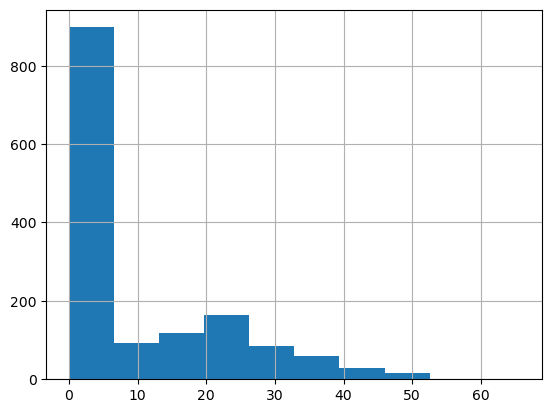

In [11]:
cnt.pct_transit_commuters_ami.hist()

# ACS Income

In [12]:
acs_inc = pd.read_csv(data_dir + 'ACS/income_NYS_2017_zcta/ACSST5Y2021.S1901-Data.csv')
acs_inc = acs_inc.iloc[2:, :]
acs_inc = acs_inc[['GEO_ID','NAME','S1901_C01_012E']]
acs_inc['ZCTA5'] = acs_inc['GEO_ID'].str.strip().str[-5:]
acs_inc = acs_inc.drop(acs_inc[acs_inc.S1901_C01_012E.str.contains(r'[^0-9a-zA-Z]')].index)
acs_inc['ZCTA5'] = pd.to_numeric(acs_inc['ZCTA5'])
acs_inc['S1901_C01_012E'] = pd.to_numeric(acs_inc['S1901_C01_012E'])
acs_inc = acs_inc.rename(columns = {'S1901_C01_012E':'MedianIncome'})
acs_inc.head()

,GEO_ID,NAME,MedianIncome,ZCTA5
2,860Z200US06390,ZCTA5 06390,46250,6390
3,860Z200US10001,ZCTA5 10001,101409,10001
4,860Z200US10002,ZCTA5 10002,37093,10002
5,860Z200US10003,ZCTA5 10003,137533,10003
6,860Z200US10004,ZCTA5 10004,216017,10004


# ASC education

In [13]:
# S1501_C01_015E
acs_edu = pd.read_csv(data_dir + 'ACS/education_NYS_zip_2021/ACSST5Y2021.S1501-Data.csv')
acs_edu = acs_edu.iloc[3:, :]
acs_edu = acs_edu[['GEO_ID','NAME','S1501_C01_015E', # Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over!!Bachelor's degree or higher
                    'S1501_C01_006E']] # Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT!!Population 25 years and over
acs_edu['ZCTA5'] = acs_edu['GEO_ID'].str.strip().str[-5:]
acs_edu['ZCTA5'] = pd.to_numeric(acs_edu['ZCTA5'])
acs_edu['S1501_C01_015E'] = pd.to_numeric(acs_edu['S1501_C01_015E'])
acs_edu['S1501_C01_006E'] = pd.to_numeric(acs_edu['S1501_C01_006E'])
acs_edu['Bachelor_prop'] = acs_edu['S1501_C01_015E']/acs_edu['S1501_C01_006E']*100
acs_edu.head()

,GEO_ID,NAME,S1501_C01_015E,S1501_C01_006E,ZCTA5,Bachelor_prop
3,860Z200US10002,ZCTA5 10002,22098,60747,10002,36.377105
4,860Z200US10003,ZCTA5 10003,30962,37589,10003,82.369842
5,860Z200US10004,ZCTA5 10004,3499,3624,10004,96.550773
6,860Z200US10005,ZCTA5 10005,6329,6829,10005,92.678284
7,860Z200US10006,ZCTA5 10006,2600,2924,10006,88.919289


# ACS Race

In [14]:
acs_race = pd.read_csv(data_dir + 'ACS/demo and houseing_NYS_zip_2021/ACSDP5Y2021.DP05-Data.csv')
acs_race = acs_race.iloc[3:, :]
acs_race = acs_race[['GEO_ID','NAME','DP05_0001E', # Estimate!!SEX AND AGE!!Total population
                   'DP05_0037E',# Estimate!!RACE!!Total population!!One race!!White
                    'DP05_0029E',# Estimate!!SEX AND AGE!!Total population!!65 years and over
                    'DP05_0003E']] # Estimate!!SEX AND AGE!!Total population!!Female
acs_race['ZCTA5'] = acs_race['GEO_ID'].str.strip().str[-5:]
# acs_race = acs_inc.drop(acs_inc[acs_inc.S1901_C01_012E.str.contains(r'[^0-9a-zA-Z]')].index)
acs_race['ZCTA5'] = pd.to_numeric(acs_race['ZCTA5'])
acs_race['DP05_0037E'] = pd.to_numeric(acs_race['DP05_0037E'])
acs_race['DP05_0001E'] = pd.to_numeric(acs_race['DP05_0001E'])
acs_race['DP05_0029E'] = pd.to_numeric(acs_race['DP05_0029E'])
acs_race['DP05_0003E'] = pd.to_numeric(acs_race['DP05_0003E'])
acs_race['White_prop'] = acs_race['DP05_0037E']/acs_race['DP05_0001E']*100
acs_race['Elderly_prop'] = acs_race['DP05_0029E']/acs_race['DP05_0001E']*100
acs_race['Female_prop'] = acs_race['DP05_0003E']/acs_race['DP05_0001E']*100
acs_race.head()

,GEO_ID,NAME,DP05_0001E,DP05_0037E,DP05_0029E,DP05_0003E,ZCTA5,White_prop,Elderly_prop,Female_prop
3,860Z200US10002,ZCTA5 10002,76807,24687,17548,38167,10002,32.141602,22.846876,49.692085
4,860Z200US10003,ZCTA5 10003,54447,38481,7699,27228,10003,70.676070,14.140357,50.008265
5,860Z200US10004,ZCTA5 10004,4795,2758,256,2256,10004,57.518248,5.338895,47.049009
6,860Z200US10005,ZCTA5 10005,8637,6496,86,4757,10005,75.211300,0.995716,55.076994
7,860Z200US10006,ZCTA5 10006,3894,2526,56,2049,10006,64.869029,1.438110,52.619414


In [15]:
acs_race[acs_race.ZCTA5==14850]

,GEO_ID,NAME,DP05_0001E,DP05_0037E,DP05_0029E,DP05_0003E,ZCTA5,White_prop,Elderly_prop,Female_prop
1787,860Z200US14850,ZCTA5 14850,67991,49868,9205,34107,14850,73.345002,13.538557,50.163992


# ASC Rent

In [16]:
acs_rent = pd.read_csv(data_dir + 'ACS/rent_NYS_zip_2021/ACSDP5Y2021.DP04-Data.csv')
acs_rent = acs_rent.iloc[3:, :]
acs_rent = acs_rent[['GEO_ID','NAME','DP04_0047E', # Estimate!!HOUSING TENURE!!Occupied housing units!!Renter-occupied
                    'DP04_0001E',# Estimate!!HOUSING OCCUPANCY!!Total housing units
                    'DP04_0057E', # Estimate!!VEHICLES AVAILABLE!!Occupied housing units
                    'DP04_0058E']]  # Estimate!!VEHICLES AVAILABLE!!Occupied housing units!!No vehicles available
acs_rent['ZCTA5'] = acs_rent['GEO_ID'].str.strip().str[-5:]
acs_rent['ZCTA5'] = pd.to_numeric(acs_rent['ZCTA5'])
acs_rent['DP04_0047E'] = pd.to_numeric(acs_rent['DP04_0047E'])
acs_rent['DP04_0001E'] = pd.to_numeric(acs_rent['DP04_0001E'])
acs_rent['DP04_0057E'] = pd.to_numeric(acs_rent['DP04_0057E'])
acs_rent['DP04_0058E'] = pd.to_numeric(acs_rent['DP04_0058E'])
acs_rent['Rent_prop'] = acs_rent['DP04_0047E']/acs_rent['DP04_0001E']*100
acs_rent['Zero_veh_prop'] = acs_rent['DP04_0058E']/acs_rent['DP04_0057E']*100
acs_rent.head()

,GEO_ID,NAME,DP04_0047E,DP04_0001E,DP04_0057E,DP04_0058E,ZCTA5,Rent_prop,Zero_veh_prop
3,860Z200US10002,ZCTA5 10002,28887,37713,34737,28910,10002,76.596929,83.225379
4,860Z200US10003,ZCTA5 10003,15936,30843,25181,20012,10003,51.668126,79.472618
5,860Z200US10004,ZCTA5 10004,1249,2760,2113,1463,10004,45.253623,69.238050
6,860Z200US10005,ZCTA5 10005,3987,6358,4782,4369,10005,62.708399,91.363446
7,860Z200US10006,ZCTA5 10006,1643,2394,1991,1637,10006,68.629908,82.219990


In [17]:
acs_rent.Rent_prop.describe()

count    1758.000000
mean       22.104138
std        19.509165
min         0.000000
25%         9.103651
50%        16.351685
75%        29.117909
max       100.000000
Name: Rent_prop, dtype: float64

# SLD

dictionary: https://www.epa.gov/sites/default/files/2021-06/documents/epa_sld_3.0_technicaldocumentationuserguide_may2021.pdf

In [18]:
sld = pd.read_csv(data_dir + 'SLD/SmartLocationDatabase_NYS.csv')
sld['TRACTCE'] = pd.to_numeric(sld['TRACTCE'])
sld = sld.rename(columns={'TRACTCE':'TRACT'})
print(len(sld))
sld.head(2)

15463


,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACT,BLKGRPCE,CSA,CSA_Name,CBSA,CBSA_Name,CBSA_POP,CBSA_EMP,CBSA_WRK,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,TotPop,CountHU,HH,P_WrkAge,AutoOwn0,Pct_AO0,AutoOwn1,Pct_AO1,AutoOwn2p,Pct_AO2p,Workers,R_LowWageWk,R_MedWageWk,R_HiWageWk,R_PCTLOWWAGE,TotEmp,E5_Ret,E5_Off,E5_Ind,E5_Svc,E5_Ent,E8_Ret,E8_off,E8_Ind,E8_Svc,E8_Ent,E8_Ed,E8_Hlth,E8_Pub,E_LowWageWk,E_MedWageWk,E_HiWageWk,E_PctLowWage,D1A,D1B,D1C,D1C5_RET,D1C5_OFF,D1C5_IND,D1C5_SVC,D1C5_ENT,D1C8_RET,D1C8_OFF,D1C8_IND,D1C8_SVC,D1C8_ENT,D1C8_ED,D1C8_HLTH,D1C8_PUB,D1D,D1_FLAG,D2A_JPHH,D2B_E5MIX,D2B_E5MIXA,D2B_E8MIX,D2B_E8MIXA,D2A_EPHHM,D2C_TRPMX1,D2C_TRPMX2,D2C_TRIPEQ,D2R_JOBPOP,D2R_WRKEMP,D2A_WRKEMP,D2C_WREMLX,D3A,D3AAO,D3AMM,D3APO,D3B,D3BAO,D3BMM3,D3BMM4,D3BPO3,D3BPO4,D4A,D4B025,D4B050,D4C,D4D,D4E,D5AR,D5AE,D5BR,D5BE,D5CR,D5CRI,D5CE,D5CEI,D5DR,D5DRI,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Region,Households,Workers_1,Residents,Drivers,Vehicles,White,Male,Lowwage,Medwage,Highwage,W_P_Lowwage,W_P_Medwage,W_P_Highwage,GasPrice,logd1a,logd1c,logd3aao,logd3apo,d4bo25,d5dei_1,logd4d,UPTpercap,B_C_constant,B_C_male,B_C_ld1c,B_C_drvmveh,B_C_ld1a,B_C_ld3apo,B_C_inc1,B_C_gasp,B_N_constant,B_N_inc2,B_N_inc3,B_N_white,B_N_male,B_N_drvmveh,B_N_gasp,B_N_ld1a,B_N_ld1c,B_N_ld3aao,B_N_ld3apo,B_N_d4bo25,B_N_d5dei,B_N_UPTpc,C_R_Households,C_R_Pop,C_R_Workers,C_R_Drivers,C_R_Vehicles,C_R_White,C_R_Male,C_R_Lowwage,C_R_Medwage,C_R_Highwage,C_R_DrmV,NonCom_VMT_Per_Worker,Com_VMT_Per_Worker,VMT_per_worker,VMT_tot_min,VMT_tot_max,VMT_tot_avg,GHG_per_worker,Annual_GHG,SLC_score,Shape_Length,Shape_Area
0,148834,360150102001,360150102001,36,15,10200,1,236.0,"Elmira-Corning, NY",21300.0,"Elmira, NY",85740,34914,34493,10360.520489,5.450285,10355.070204,10355.070204,809,303,273,0.623,0,0.00000,30,0.109890,243,0.89011,290,60,91,139,0.206897,118,0,21,21,47,29,0,0,21,47,29,0,0,21,77,26,15,0.652542,0.029261,0.078126,0.011395,0.000000,0.002028,0.002028,0.004539,0.002801,0.000000,0.000000,0.002028,0.004539,0.002801,0.000000,0.0,0.002028,0.040656,0,0.432234,0.956472,0.823860,0.956472,0.637648,0.629122,0.615556,0.663472,0.933267,0.254585,0.578431,2.457627,0.232788,2.049676,0.420606,0.249756,1.379314,1.092412,0.679860,0.432638,0.00000,1.112498,0.061805,-99999.0,0.0,0.0,-99999.0,-99999.0,-99999.0,4233,3941,-99999,-99999,0.004778,0.283125,0.005227,0.326215,-99999.0,-99999.0,-99999.0,-99999.0,14,13,1,1,5.166667,"Elmira, NY Metro Area",313,290,941,611.60,NaN,906,437,60,91,139,0.652542,0.220339,0.127119,251,0.028841,0.011331,0.351084,0.866812,0,0,0,0,0.873293,-0.04426,0.166539,0.020884,-0.307095,-0.217563,-0.504419,0.009753,2.860975,0.193016,0.105974,-0.015546,0.122841,-0.239417,-0.003407,-0.226525,-0.226525,0.156803,-0.270989,-0.598029,0.183503,-0.000690,33989,84895,34493,59181.76,49199,0.862277,0.495388,0.244281,0.340533,0.415186,0.293706,7.391859,17.991129,25.382988,7.690275,32.722666,19.519636,22.616242,5880.222946,29.320723,36464.422442,4.192845e+07
1,148835,360630243032,360630243032,36,63,24303,2,160.0,"Buffalo-Cheektowaga-Olean, NY",15380.0,"Buffalo-Cheektowaga, NY",1131570,546694,525947,8439.361232,0.000000,8439.361232,8439.361232,1831,638,638,0.603,27,0.04232,165,0.258621,446,0.69906,813,185,217,411,0.227552,108,7,1,76,24,0,7,1,76,17,0,7,0,0,56,37,15,0.518519,0.075598,0.216960,0.012797,0.000829,0.000118,0.009005,0.002844,0.000000,0.000829,0.000118,0.009005,0.002014,0.000000,0.000829,0.0,0.000000,0.088395,0,0.169279,0.578680,0.498447,0.581794,0.450295,0.329104,0.276044,0.254029,0.003466,0.111398,0.234528,7.527778,0.001462,2.197988,0.333360,1.129881,0.734747,1.466803,0.682516,1.592538,0.15167,0.379176,0.000000,-99999.0,0.0,0.0,-99999.0,-99999.0,-99999.0,22454,23236,-99999,-99999,0.000380,0.216126,0.000455,0.264132,-99999.0,-99999.0,-99999.0,-99999.0,6,7,2,1,3.166667,"Buffalo-Cheektowaga, NY Metro Area",628,813,1713,1268.96,1357.0,1675,819,185,217,411,0.518519,0.342593,0.138889,251,0.072877,0.012716,0.287702,0.550862,0,0,0,21,3.866222,-0.05563,0.0058

In [20]:
sld = pd.read_csv(data_dir + 'SLD/SmartLocationDatabase_NYS.csv')
sld['TRACTCE'] = pd.to_numeric(sld['TRACTCE'])
sld = sld.rename(columns={'TRACTCE':'TRACT'})

sld['D4A'] = sld['D4A'].apply(lambda x: sld['D4A'].max() if x==-99999 else x)
sld['D4D'] = sld['D4D'].apply(lambda x: 0 if x==-99999 else x)
sld['D5BR'] = sld['D5BR'].apply(lambda x: 0 if x==-99999 else x)

# group to tract level (rather than block group)
sld = sld.groupby('TRACT').mean().reset_index()

# remove census tracts
sld = pd.merge(z_tract[['ZCTA5','TRACT']],sld,how='left',on='TRACT')
print(len(sld))

# Numerical data
# density: 'D1a','D1B','D1C','D1C5_RET','D1C5_OFF'
# design: 'D3AAO','D3APO'
# diversity: 'D2B_E5MIX','D2A_EPHHM'
# transit: 'D4A','D4D'
# destination: 'D5AR'
sld_var = ['D1A','D1B','D1C','D1C5_RET','D1C5_OFF',
          'D3AAO','D3APO',
          'D2B_E5MIX','D2A_EPHHM',
          'D4A','D4D',
          'D5AR','D5BR']

1473


In [21]:
sld.D2A_EPHHM.isin([np.inf, -np.inf]).any()

False

# ev ownership

In [22]:
ev = pd.read_csv(data_dir + 'NYS open portal/EV share/EV share_Dec21.csv')
ev = ev[ev["Row Labels"].str.contains("County") == False]
ev = ev[ev["Row Labels"].str.contains("(blank)") == False]
ev['EVs per 1k People'] = ev['EVs per 1k People'].fillna(0)
ev = ev.rename(columns={"Row Labels":'ZCTA5'})
ev = ev[pd.to_numeric(ev['ZCTA5'], errors='coerce').notnull()]
ev['ZCTA5'] = pd.to_numeric(ev['ZCTA5']) 

ev = ev.rename(columns={'EVs per 1k People':'ev_rate'})

ev = ev[ev.ZCTA5.isin(z_tract.ZCTA5.values)] # New York has a total of 1794 active zip codes.
# ev = ev[ev.ev_rate>0]
# ev = ev[ev.ev_rate<50]
print(len(ev))
ev.head()

1473


,ZCTA5,BEVs per 1k People,PHEVs per 1k People,ev_rate,BEVs on the Road,PHEVs on the Road,EVs on the Road,DCFC Ports,Level 2 Ports,DCFC Ports per 1k People,Level 2 Ports per 1k People
1,12007,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12009,4.303797,5.189873,9.493671,34.0,41.0,75.0,1.0,17.0,0.126582,2.151899
3,12023,1.828989,3.657979,5.486968,4.0,8.0,12.0,NaN,NaN,NaN,NaN
4,12041,0.000000,3.502627,3.502627,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,12045,0.000000,7.905138,7.905138,NaN,4.0,4.0,NaN,NaN,NaN,NaN


# Charging stations

In [23]:
station = pd.read_csv(data_dir+'NYS open portal/Charging/Alternative_Fuel_Stations_in_New_York w.County.csv')
station['year_open'] = pd.to_numeric(station['date_open_'].str[:4])
station['CNTYFIPS'] = station['FIPS'].astype(str).str[:5]
print(len(station))
print(len(np.unique(station.id)))
station = station[station.year_open<=2021]
station = station[station.fuel_type_=='ELEC']
print(len(station))
print(len(np.unique(station.id)))

zip_zcta5 = pd.read_excel(data_dir + 'NYS open portal/ZIPCodetoZCTACrosswalk2020UDS.xlsx',sheet_name=0)  
zip_zcta5 = zip_zcta5[zip_zcta5.STATE=='NY']
zip_zcta5['ZCTA'] = pd.to_numeric(zip_zcta5['ZCTA'])
zip_zcta5 = zip_zcta5.rename(columns={'ZIP_CODE':'zip'})
station = pd.merge(station,zip_zcta5,how='left',on='zip')

station_num = station.groupby('ZCTA')['id'].count().reset_index().rename(columns={'ZCTA':'ZCTA5','id':'NumStations'})
# station_num = pd.merge(station_num,z_tract[['ZCTA5','ZAREA']],how='left',on='ZCTA5')
# station_num['ZAREA'] = station_num['ZAREA'].fillna(station_num['ZAREA'].mean())
# station_num['NumStations'] = station_num['NumStations'].fillna(0)
# station_num['DensityStations'] = station_num['NumStations']/station_num['ZAREA'] * 2.59e+6
# # station_num[station_num.isna().any(axis=1)]
# station_num = station_num[station_num.ZAREA>10e+7]
station_num = pd.merge(ev[['ZCTA5']],station_num,on='ZCTA5',how='left')
station_num.head()

3401
3401
2253
2253


,ZCTA5,NumStations
0,12007,NaN
1,12009,4.0
2,12023,NaN
3,12041,NaN
4,12045,NaN


In [24]:
from numpy import nansum
for i in [10]: # 5,10,25,50,75,100
    x = gpd.read_file(map_dir+'spatial paper/variables/charging stations ('+str(i)+'-mile combined).shp')
    tmp = x.groupby(['ZCTA5_2']).agg({'NumStation':nansum}).reset_index().rename(columns={'ZCTA5_2':'ZCTA5','NumStation':'NumStation_'+str(i)})
    station_num = pd.merge(station_num,tmp,on='ZCTA5',how='left')
    print(len(x))
print(len(station_num))
station_num.head()

26161
1473


,ZCTA5,NumStations,NumStation_10
0,12007,NaN,1.0
1,12009,4.0,38.0
2,12023,NaN,4.0
3,12041,NaN,47.0
4,12045,NaN,31.0


# Model input

In [30]:
inp = pd.merge(ev[['ZCTA5','ev_rate']],acs_race[['ZCTA5','White_prop','Elderly_prop']],how='left',on='ZCTA5')
# cols = ['NumStations','NumStation_5','NumStation_10',
#         'NumStation_25','NumStation_50','NumStation_75','NumStation_100']
cols = ['NumStation_10']
inp = pd.merge(inp,station_num[['ZCTA5']+cols],on='ZCTA5',how='left')
inp[cols] = inp[cols].fillna(0)
inp['ev_rate'] = inp['ev_rate'].fillna(0)

inp = pd.merge(inp,acs_edu[['ZCTA5','Bachelor_prop']],how='left',on='ZCTA5') 
inp = pd.merge(inp,acs_rent[['ZCTA5','Rent_prop','Zero_veh_prop']],how='left',on='ZCTA5') 
inp = pd.merge(inp,sld[['ZCTA5']+sld_var],how='left',on='ZCTA5') 
inp = pd.merge(inp,cnt[['ZCTA5']+cnt_var],how='left',on='ZCTA5') # 
print(len(inp))
inp = inp.dropna()
# inp = pd.merge(inp,acs_inc[['ZCTA5','MedianIncome']],how='left',on='ZCTA5') 
print(len(inp))

inp['ev_rate_adj'], lambda_value = stats.boxcox(inp['ev_rate']+1) # np.log(inp['ev_rate']+1)

inp['Rent_Near_Emp'] = inp['Rent_prop'] * inp['D1C5_OFF']
# inp = inp[inp.Zero_veh_prop<=50]
# inp.loc[inp.isnull().any(axis=1)]
inp['NumStation_10'], lambda_value = stats.boxcox(inp['NumStation_10']+1) # Apply the Cox-Box transformation
inp['D5BR'], lambda_value = stats.boxcox(inp['D5BR']+1) # Apply the Cox-Box transformation

inp = pd.merge(inp,zips[['ZCTA5','geometry']],how='left',on='ZCTA5')
inp = gpd.GeoDataFrame(inp, geometry=inp.geometry)
%store inp
print(len(inp))
inp.head(2)

1473
1422
Stored 'inp' (GeoDataFrame)
1422


,ZCTA5,ev_rate,White_prop,Elderly_prop,NumStation_10,Bachelor_prop,Rent_prop,Zero_veh_prop,D1A,D1B,D1C,D1C5_RET,D1C5_OFF,D3AAO,D3APO,D2B_E5MIX,D2A_EPHHM,D4A,D4D,D5AR,D5BR,h_ami,t_ami,ev_rate_adj,Rent_Near_Emp,geometry
0,12007,0.000000,100.000000,30.592105,0.653407,10.958904,12.598425,5.511811,88.761563,157.043620,27.067595,1.793343,5.480141,0.517611,6.506853,0.712806,0.487343,653.697143,4450.470212,451218.428571,11.024204,33.5,16.0,0.000000,69.041143,"POLYGON ((-73.94111 42.45438, -73.94109 42.454..."
1,12009,9.493671,87.741244,19.359066,2.717592,51.955885,19.619680,2.821814,0.084824,0.190405,0.075117,0.001792,0.004505,0.265703,1.718405,0.753436,0.636400,1207.000000,0.000000,20786.666667,0.000000,34.0,24.0,2.168356,0.088390,"POLYGON ((-74.13791 42.64384, -74.13750 42.644..."


In [ ]:
inp['D2A_EPHHM'].isin([np.inf, -np.inf]).any()

False

In [ ]:
ev_map = pd.merge(ev,zips[['ZCTA5','geometry']],how='left',on='ZCTA5')
ev_map = gpd.GeoDataFrame(ev_map, geometry=inp.geometry)
# ev_map.to_file('ev.shp')

In [ ]:
# len(inp[inp.NumStations!=0])
# intersection = (list(set(inp.ZCTA5) & set(station_num.ZCTA5)))
# station_num[~station_num.ZCTA5.isin(intersection)]

In [ ]:
# inp.to_file('variables.shp')

In [ ]:
# benchmark
inp_var = ['White_prop','Elderly_prop','Bachelor_prop','MedianIncome','Rent_prop',
           'Rent_Near_Emp',
           'D1A','D1C','D1C5_RET','D1C5_OFF', # remove 'D1B'
           'D3AAO','D3APO',
           'D2B_E5MIX','D2A_EPHHM',
           'D4A','D4D',
           'D5AR',
           'h_ami',
           'DensityStations']
inp_var = ['Elderly_prop','Bachelor_prop','Rent_prop',
#            'Rent_Near_Emp',
#            'D1A',
           'D3APO',
           'D2A_EPHHM',
#            'D4A',
           'D5AR',
           'h_ami',
           'NumStations']

#gather features
features = "+".join(inp_var)

# get y and X dataframes based on this regression:
y, X = dmatrices('ev_rate_adj ~' + features, inp[inp_var+["ev_rate_adj"]], return_type='dataframe')

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

vif.round(1)

,VIF Factor,features
0,39.4,Intercept
1,1.1,Elderly_prop
2,1.4,Bachelor_prop
3,1.3,Rent_prop
4,1.6,D3APO
5,1.1,D2A_EPHHM
6,1.5,D5AR
7,1.4,h_ami
8,1.1,NumStations


In [ ]:
X.describe()

,Intercept,Elderly_prop,Bachelor_prop,Rent_prop,D3APO,D2A_EPHHM,D5AR,h_ami,NumStations
count,1422.0,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000,1422.000000
mean,1.0,21.062862,31.972992,18.251671,7.259566,0.501788,128988.540813,28.082602,0.782700
std,0.0,11.214309,18.671801,16.026675,5.308461,0.105412,166124.712414,7.131027,2.448319
min,1.0,0.000000,0.000000,0.000000,0.422415,0.000000,234.200000,0.000000,0.000000
25%,1.0,15.197337,18.568627,8.246506,2.523231,0.442869,4547.967742,24.000000,0.000000
50%,1.0,19.129195,27.762260,14.792996,6.320239,0.496423,24907.250000,26.333333,0.000000
75%,1.0,24.074589,42.281081,23.488562,10.596016,0.570766,234175.255952,31.000000,1.000000
max,1.0,100.000000,100.000000,100.000000,34.864669,0.902603,777701.000000,60.000000,25.000000


In [ ]:
inp['ev_rate'].describe()

count    1422.000000
mean        6.386521
std         9.474004
min         0.000000
25%         1.802208
50%         3.692868
75%         7.687389
max       146.341463
Name: ev_rate, dtype: float64